# Mohammad Amin Amiri



#**Introduction to PyTorch**
**Fill in the code parts with ### and Run your code**

In [1]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## Learning by example: Continuous XOR

If we want to build a neural network in PyTorch, we could specify all our parameters (weight matrices, bias vectors) using `Tensors` (with `requires_grad=True`), ask PyTorch to calculate the gradients and then adjust the parameters.

This is a simple example classifier on a simple yet well known example: XOR. Given two binary inputs $x_1$ and $x_2$, the label to predict is $1$ if either $x_1$ or $x_2$ is $1$ while the other is $0$, or the label is $0$ in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function. Hence, we will learn how to build a small neural network that can learn this function.
To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

<center style="width: 100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/continuous_xor.svg?raw=1" width="350px"></center>

### The model

The package `torch.nn` defines a series of useful classes like linear networks layers, activation functions, loss functions etc. A full list can be found [here](https://pytorch.org/docs/stable/nn.html). In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already. Additionally to `torch.nn`, there is also `torch.nn.functional`. It contains functions that are used in network layers. We import them below:

In [2]:
import torch
# Import
from torch import nn
from torch.nn import functional


#### Simple classifier
We can now make use of the pre-defined modules in the `torch.nn` package, and define our own small neural network. We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer. In other words, our networks should look something like this:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/small_neural_network.svg?raw=1" width="300px"></center>

The input neurons are shown in blue, which represent the coordinates $x_1$ and $x_2$ of a data point. The hidden neurons including a tanh activation are shown in white, and the output neuron in red.
In PyTorch, we can define this as follows:

In [3]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        self.tanh = nn.Tanh()


    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        ###
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x

In [4]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
  (tanh): Tanh()
)


### The data

PyTorch also provides a few functionalities to load the training and test data efficiently, summarized in the package `torch.utils.data`.

In [5]:
import torch.utils.data as data

#### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [6]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

Let's try to create such a dataset and inspect it:

In [7]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.0044, 1.0708]), tensor(1))


To better relate to the dataset, we visualize the samples below.

In [8]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

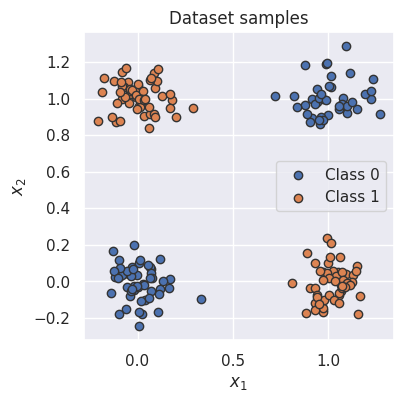

In [9]:
visualize_samples(dataset.data, dataset.label)
plt.show()

#### The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features.
In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input.

Let's create a simple data loader with batch size 8 and True shuffle below:

In [10]:
# Creating dataloader
###
data.DataLoader(dataset, batch_size=8, shuffle=True)

### Optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

We have seen how we can do step 1, 2 and 4 in PyTorch. Now, we will look at step 3 and 5.

#### Loss modules

We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. However, PyTorch already provides a list of predefined loss functions which we can use (see [here](https://pytorch.org/docs/stable/nn.html#loss-functions) for a full list). For instance, for BCE, PyTorch has two modules: `nn.BCELoss()`, `nn.BCEWithLogitsLoss()`. While `nn.BCELoss` expects the inputs $x$ to be in the range $[0,1]$, i.e. the output of a sigmoid, `nn.BCEWithLogitsLoss` combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on "logits" where possible (remember to not apply a sigmoid on the output of the model in this case!). For our model defined above, we therefore use the module `nn.BCEWithLogitsLoss`.

In [11]:
# Use BCEWithLogitsLoss to define loss_module
###
loss_module = nn.BCEWithLogitsLoss()


In [12]:
# Set optimizer to SGD with lr - 0.1
###
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


The optimizer provides two useful functions: `optimizer.step()`, and `optimizer.zero_grad()`. The step function updates the parameters based on the gradients as explained above. The function `optimizer.zero_grad()` sets the gradients of all parameters to zero. While this function seems less relevant at first, it is a crucial pre-step before performing backpropagation. If we call the `backward` function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwriting them. This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them. Hence, remember to call `optimizer.zero_grad()` before calculating the gradients of a batch.

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size 128 and shuffle True.

In [13]:
# Dataset and DataLoader
###
train_dataset = XORDataset(size=5000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In addition, we set our model to training mode. This is done by calling `model.train()`. There exist certain modules that need to perform a different forward step during training than during testing (e.g. BatchNorm and Dropout), and we can switch between them using `model.train()` and `model.eval()`.

In [14]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    ###


    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Run the model on the input data
            ###
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 2: Calculate the loss
            ###
            loss = loss_module(preds, data_labels.float())

            ## Step 3: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            ###
            optimizer.zero_grad()

            # Perform backpropagation
            ###
            loss.backward()


            ## Step 4: Update the parameters
            ###
            optimizer.step()


In [15]:
#Train the model
###
train_model(model, optimizer, train_data_loader, loss_module)


  0%|          | 0/100 [00:00<?, ?it/s]

#### Saving a model

After finish training a model, we save the model to disk so that we can load the same weights at a later time. For this, we extract the so-called `state_dict` from the model which contains all learnable parameters. For our simple model, the state dict contains the following entries:

In [16]:
#Define state_dict to save
###

state_dict = model.state_dict()

In [17]:
# Save the model. For the filename, any extension can be used, use the name "our_model"
###
torch.save(state_dict, "our_model")


To load a model from a state dict, we use the function `torch.load` to load the state dict from the disk, and the module function `load_state_dict` to overwrite our parameters with the new values:

In [18]:
# Load state dict from the disk (make sure it is the same name as above)
###
state_dict = torch.load("our_model")

# Create a new model and load the state
###
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)


# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-1.7732, -1.5365],
        [ 2.1361,  1.9712],
        [ 3.8540, -2.8872],
        [ 2.4369, -3.5596]])), ('linear1.bias', tensor([-0.0861, -0.2357,  1.1066, -0.8605])), ('linear2.weight', tensor([[-1.8476,  2.6863, -5.2931,  5.3009]])), ('linear2.bias', tensor([1.0594]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-1.7732, -1.5365],
        [ 2.1361,  1.9712],
        [ 3.8540, -2.8872],
        [ 2.4369, -3.5596]])), ('linear1.bias', tensor([-0.0861, -0.2357,  1.1066, -0.8605])), ('linear2.weight', tensor([[-1.8476,  2.6863, -5.2931,  5.3009]])), ('linear2.bias', tensor([1.0594]))])


A detailed tutorial on saving and loading models in PyTorch can be found [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

### Evaluation

Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.

In [19]:
#Create Test dataset and use dataloader with batch size 128 and drop_Last False
###

test_dataset = XORDataset(size=200)
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [20]:
def eval_model(model, data_loader):
    # Set model to eval mode
    ###
    model.eval()

    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            ###
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [21]:
#Evaluate model
###
eval_model(model, test_data_loader)


Accuracy of the model: 100.00%


If we trained our model correctly, we should see a score close to 100% accuracy. However, this is only possible because of our simple task, and unfortunately, we usually don't get such high scores on test sets of more complex tasks.

#### Visualizing classification boundaries

To visualize what our model has learned, we can perform a prediction for every data point in a range of $[-0.5, 1.5]$, and visualize the predicted class as in the sample figure at the beginning of this section.  The specific code is less relevant compared to the output figure which should hopefully show us a clear separation of classes:

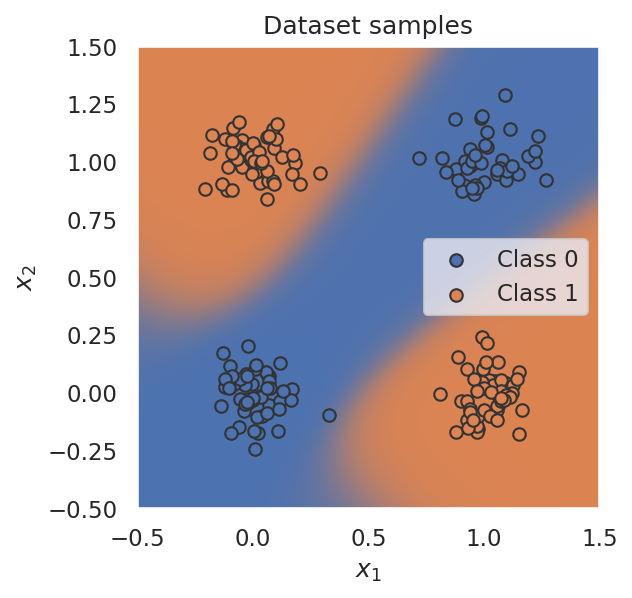

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=150)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

The decision boundaries might not look exactly as in the figure in the preamble of this section which can be caused by running it on CPU or a different GPU architecture. Nevertheless, the result on the accuracy metric should be the approximately the same.